## B1957+20 Demonstration
This notebook will run through the sampling for B1957+20, reproducing the results presented in the paper

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from shoogle.gibbs_sampler import Gibbs
from shoogle.plot_gibbs_results import GibbsResults

### Load the data and model with PINT, initialise the Gibbs sampler

The timing model in `B1957+20_shoogle_input.par` is the GPTA DR1 model, from [zenodo](https://zenodo.org/records/6374291), with extra lines for shoogle hyperparameters, WAVEX and ORBWAVEs components initialised to zero, and all timing parameters (EPS1, EPS2, PMRA, PMDEC) free to vary in the fit. 

This initial model is quite far from the best-fitting solution accounting for the orbital period variations, so the initial pulse profile does not closely resemble the eventual solution. The initial timing model is close enough that shoogle will quickly walk uphill to a good solution, but the MCMC proposal distribution used to draw samples of the template pulse profile parameters, which is based on the results of a "tuning" MCMC run using the initial pulse profile, is not well tuned. This slows everything down. 

This manifests in the initial "tuning" run not reaching convergence - shoogle will report that the autocorrelation time could not be computed reliably. 

To deal with this, we'll run the sampler for just a few steps to reach a much better solution, and re-initialise the sampler from there.  

In [2]:
psr = Gibbs(ft1file='B1957+20_GPTA_DR1.fits',
            ft2file='/Users/cclark/fermi/data/FT2.fits',
            weightfield='4FGL J1959.5+2048',
            wmin=0.05,
            parfile='B1957+20_shoogle_input.par',
            templatefile='B1957+20_shoogle_input.prof')

2025-12-28 15:33:56.585 | INFO     | pint.observatory.satellite_obs:load_Fermi_FT2:43 - Opened FT2 FITS file /Users/cclark/fermi/data/FT2.fits
2025-12-28 15:33:56.586 | INFO     | pint.observatory.satellite_obs:load_Fermi_FT2:47 - FT2 TIMESYS TT
2025-12-28 15:33:56.587 | INFO     | pint.observatory.satellite_obs:load_Fermi_FT2:49 - FT2 TIMEREF LOCAL
2025-12-28 15:33:56.588 | DEBUG    | pint.fits_utils:read_fits_event_mjds:104 - TIMEZERO = 0.0
2025-12-28 15:33:56.589 | DEBUG    | pint.fits_utils:read_fits_event_mjds:117 - MJDREF = 51910.00074287037
2025-12-28 15:33:57.692 | INFO     | pint.observatory.satellite_obs:load_Fermi_FT2:75 - Building FT2 table covering MJDs 54682.65603794185 d to 60932.106953518516 d
2025-12-28 15:34:11.543 | INFO     | pint.fermi_toas:get_Fermi_TOAs:227 - TIMESYS TT
2025-12-28 15:34:11.543 | INFO     | pint.fermi_toas:get_Fermi_TOAs:229 - TIMEREF LOCAL
2025-12-28 15:34:11.544 | DEBUG    | pint.fits_utils:read_fits_event_mjds_tuples:48 - TIMEZERO = 0.0
2025-12

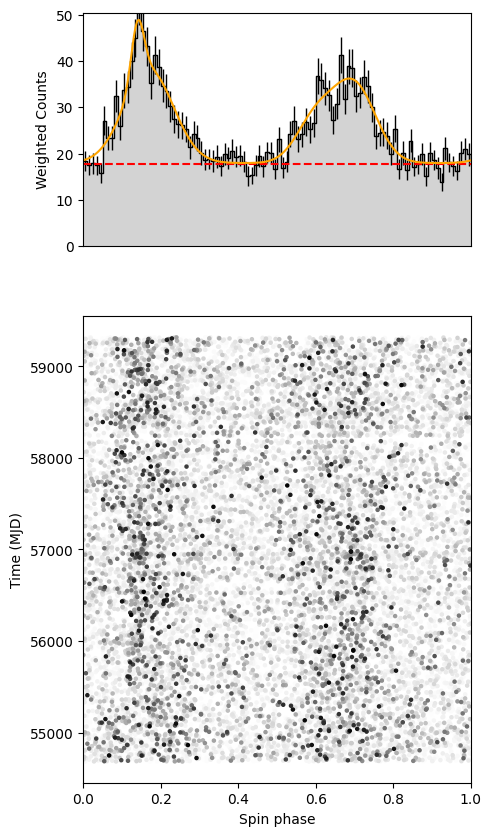

Tuning template sampler, step 2 of 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:36<00:00, 552.57it/s]


autocorr computation failed. Setting tau_autocorr_time to 400.
Tau autocorr time = nan


Tuning hyperpar sampler, step 2 of 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:24<00:00, 824.15it/s]


Lambda autocorr time = 98
0 H =  892.3376547751756 logL =  426.2519581901154 chi2 =  70.50913246630714 logdet_prior = -1789.5836086397828 logpost =  1285.789196276853
1 H =  933.46033662733 logL =  439.18544735321734 chi2 =  60.71368846546898 logdet_prior = -2904.485360293526 logpost =  1861.0712832672457
2 H =  1001.910018233644 logL =  458.7621209613468 chi2 =  104.09432879857889 logdet_prior = -1521.099776293414 logpost =  1167.2648447087643
3 H =  1058.9887632234213 logL =  470.9634663736126 chi2 =  91.99404411735506 logdet_prior = -1380.3364405034897 logpost =  1115.13466456668
4 H =  1208.6060565343 logL =  499.8333183047509 chi2 =  87.52303366141655 logdet_prior = -1856.9372470989676 logpost =  1384.5404250235265
5 H =  1302.1395797116627 logL =  516.1631030712822 chi2 =  81.64103908443175 logdet_prior = -1642.8345379152395 logpost =  1296.759852486686
6 H =  1436.6555611526812 logL =  533.0504518773382 chi2 =  68.26254604150448 logdet_prior = -1961.0874854136546 logpost =  1479

/Users/cclark/Software/fermi/shoogle_release/src/shoogle/gibbs_sampler.py:1464: RuntimeWarning: invalid value encountered in divide
  param = (


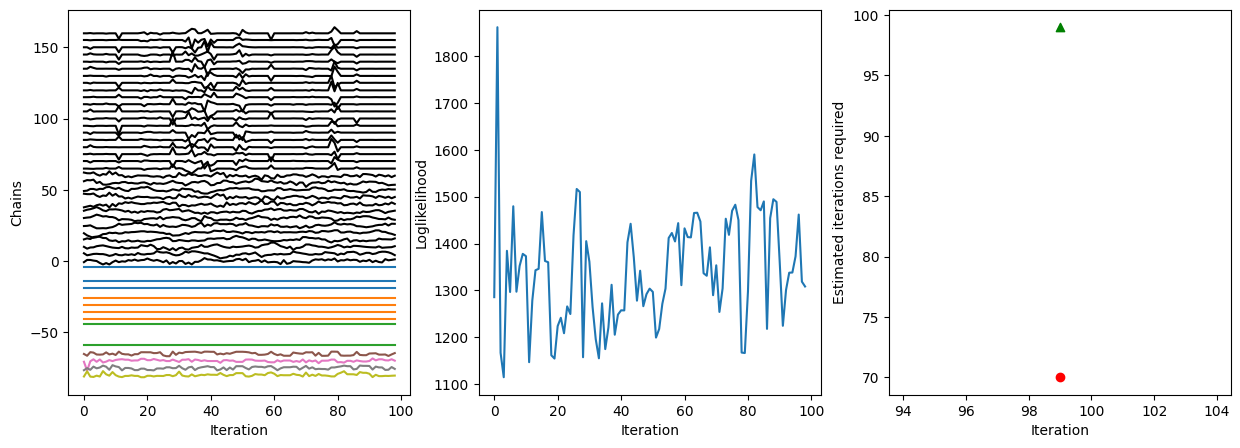

<Figure size 640x480 with 0 Axes>

In [3]:
psr.sample(ntau_target=10,update=100,outputfile='B1957+20_shoogle_output',resume=False,plots=True)

In [4]:
res = GibbsResults(psr)
res.load_results(['B1957+20_shoogle_output.npz'],decimated=True)
res.write_new_parfile('B1957+20_shoogle_output_orbwaves.par')
#res.write_new_template('B1957+20_shoogle_output_prof.txt')

## Some manual edits required at this stage
* Edit B1957+20_shoogle_output_orbwaves.par to remove all the uncertainties (which would otherwise be interpreted as priors)
* Create a new pulse profile template based on this new initial solution

In [5]:
psr = Gibbs(ft1file='B1957+20_GPTA_DR1.fits',
            ft2file='/Users/cclark/fermi/data/FT2.fits',
            weightfield='4FGL J1959.5+2048',
            wmin=0.05,
            parfile='B1957+20_shoogle_input_v2.par',
            templatefile='B1957+20_shoogle_input_v2.prof')

2025-12-28 15:40:01.168 | INFO     | pint.fermi_toas:get_Fermi_TOAs:227 - TIMESYS TT
2025-12-28 15:40:01.169 | INFO     | pint.fermi_toas:get_Fermi_TOAs:229 - TIMEREF LOCAL
2025-12-28 15:40:01.169 | DEBUG    | pint.fits_utils:read_fits_event_mjds_tuples:48 - TIMEZERO = 0.0
2025-12-28 15:40:01.170 | DEBUG    | pint.fits_utils:read_fits_event_mjds_tuples:65 - MJDREF = 51910.00074287037
2025-12-28 15:40:01.361 | INFO     | pint.fermi_toas:get_Fermi_TOAs:297 - Building spacecraft local TOAs, with MJDs in range 54683.36255794899 to 59318.39102399048
2025-12-28 15:40:02.547 | DEBUG    | pint.toa:__init__:1377 - No pulse number flags found in the TOAs
2025-12-28 15:40:02.571 | DEBUG    | pint.toa:apply_clock_corrections:2232 - Applying clock corrections (include_bipm = False)
2025-12-28 15:40:03.563 | INFO     | pint.observatory:gps_correction:230 - Applying GPS to UTC clock correction (~few nanoseconds)
2025-12-28 15:40:07.968 | DEBUG    | pint.toa:compute_TDBs:2278 - Computing TDB columns.


### Setting a uniform amplitude on A_gwb
By default, shoogle assumes uniform priors on the log-amplitudes of noise models. If this noise component is not well constrained by the data, then a 95% confidence upper limit on the amplitude will depend entirely on the lower limit of the prior on the log-amplitude.

To compute a correct upper limit on A_gwb, this prior needs to be uniform on the amplitude instead. 

In [6]:
psr.noise_models[0].linear_amp_prior = True

### Run the sampling!
This will take some time, 1-2 hours, depending on your hardware.

For a comprehensive analysis, you may want to run multiple instances in parallel to accumulate more independent samples. 

In [7]:
psr.sample(ntau_target=1000,update=100,outputfile='B1957+20_shoogle_output',resume=False,plots=False)

Tuning template sampler, step 2 of 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:28<00:00, 224.84it/s]


Tau autocorr time = 116


Tuning hyperpar sampler, step 2 of 2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [00:29<00:00, 673.49it/s]


Lambda autocorr time = 68


Gibbs sampling: 11200it [2:04:25,  1.50it/s]                                                                                                                                                          


### Create a GibbsResults object to interpret/plot the sampling results

In [13]:
res = GibbsResults(psr)
res.load_results(['B1957+20_shoogle_output.npz'],decimated=True)
res.write_new_parfile('B1957+20_shoogle_output_orbwaves.par')
res.write_new_template('B1957+20_shoogle_output_prof.txt')


### Make a corner plot of the OPV/TN hyperparameters (Fig. 5 from the paper)

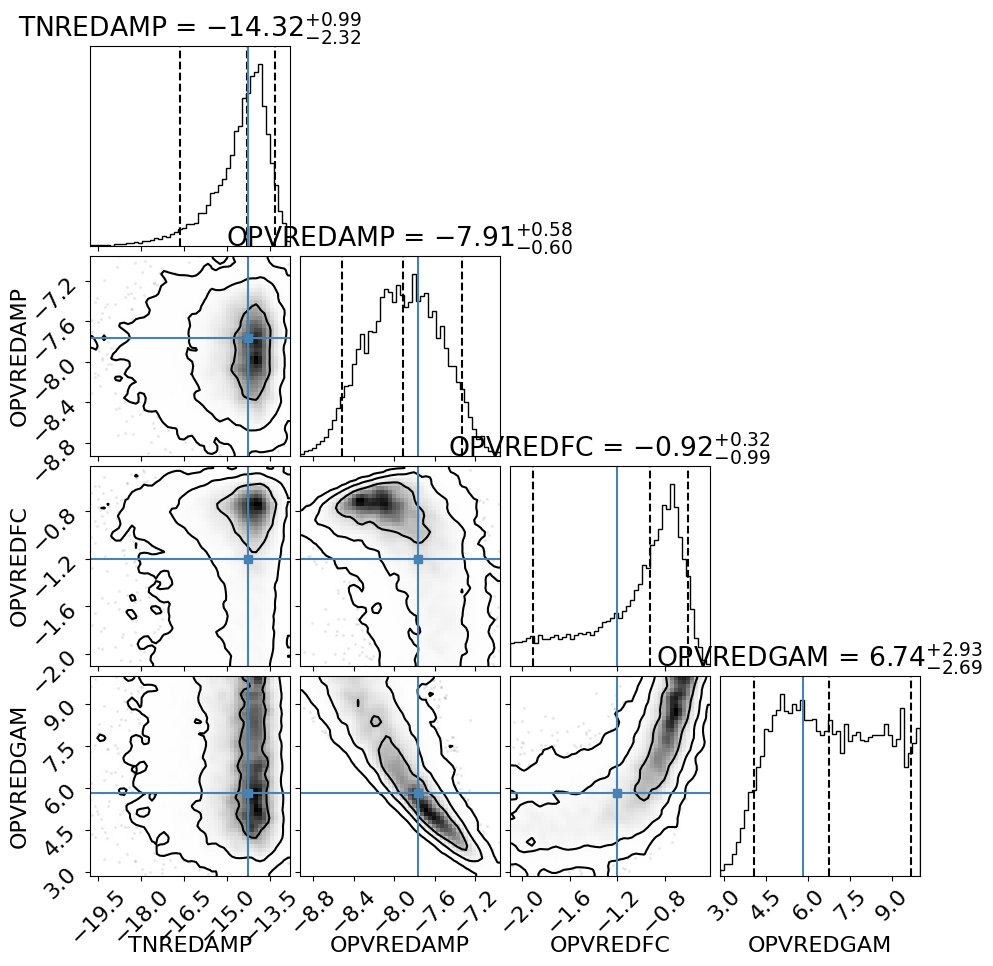

In [14]:
fig = res.hyp_corner()
plt.show()

### Make a corner plot of the timing model parameters

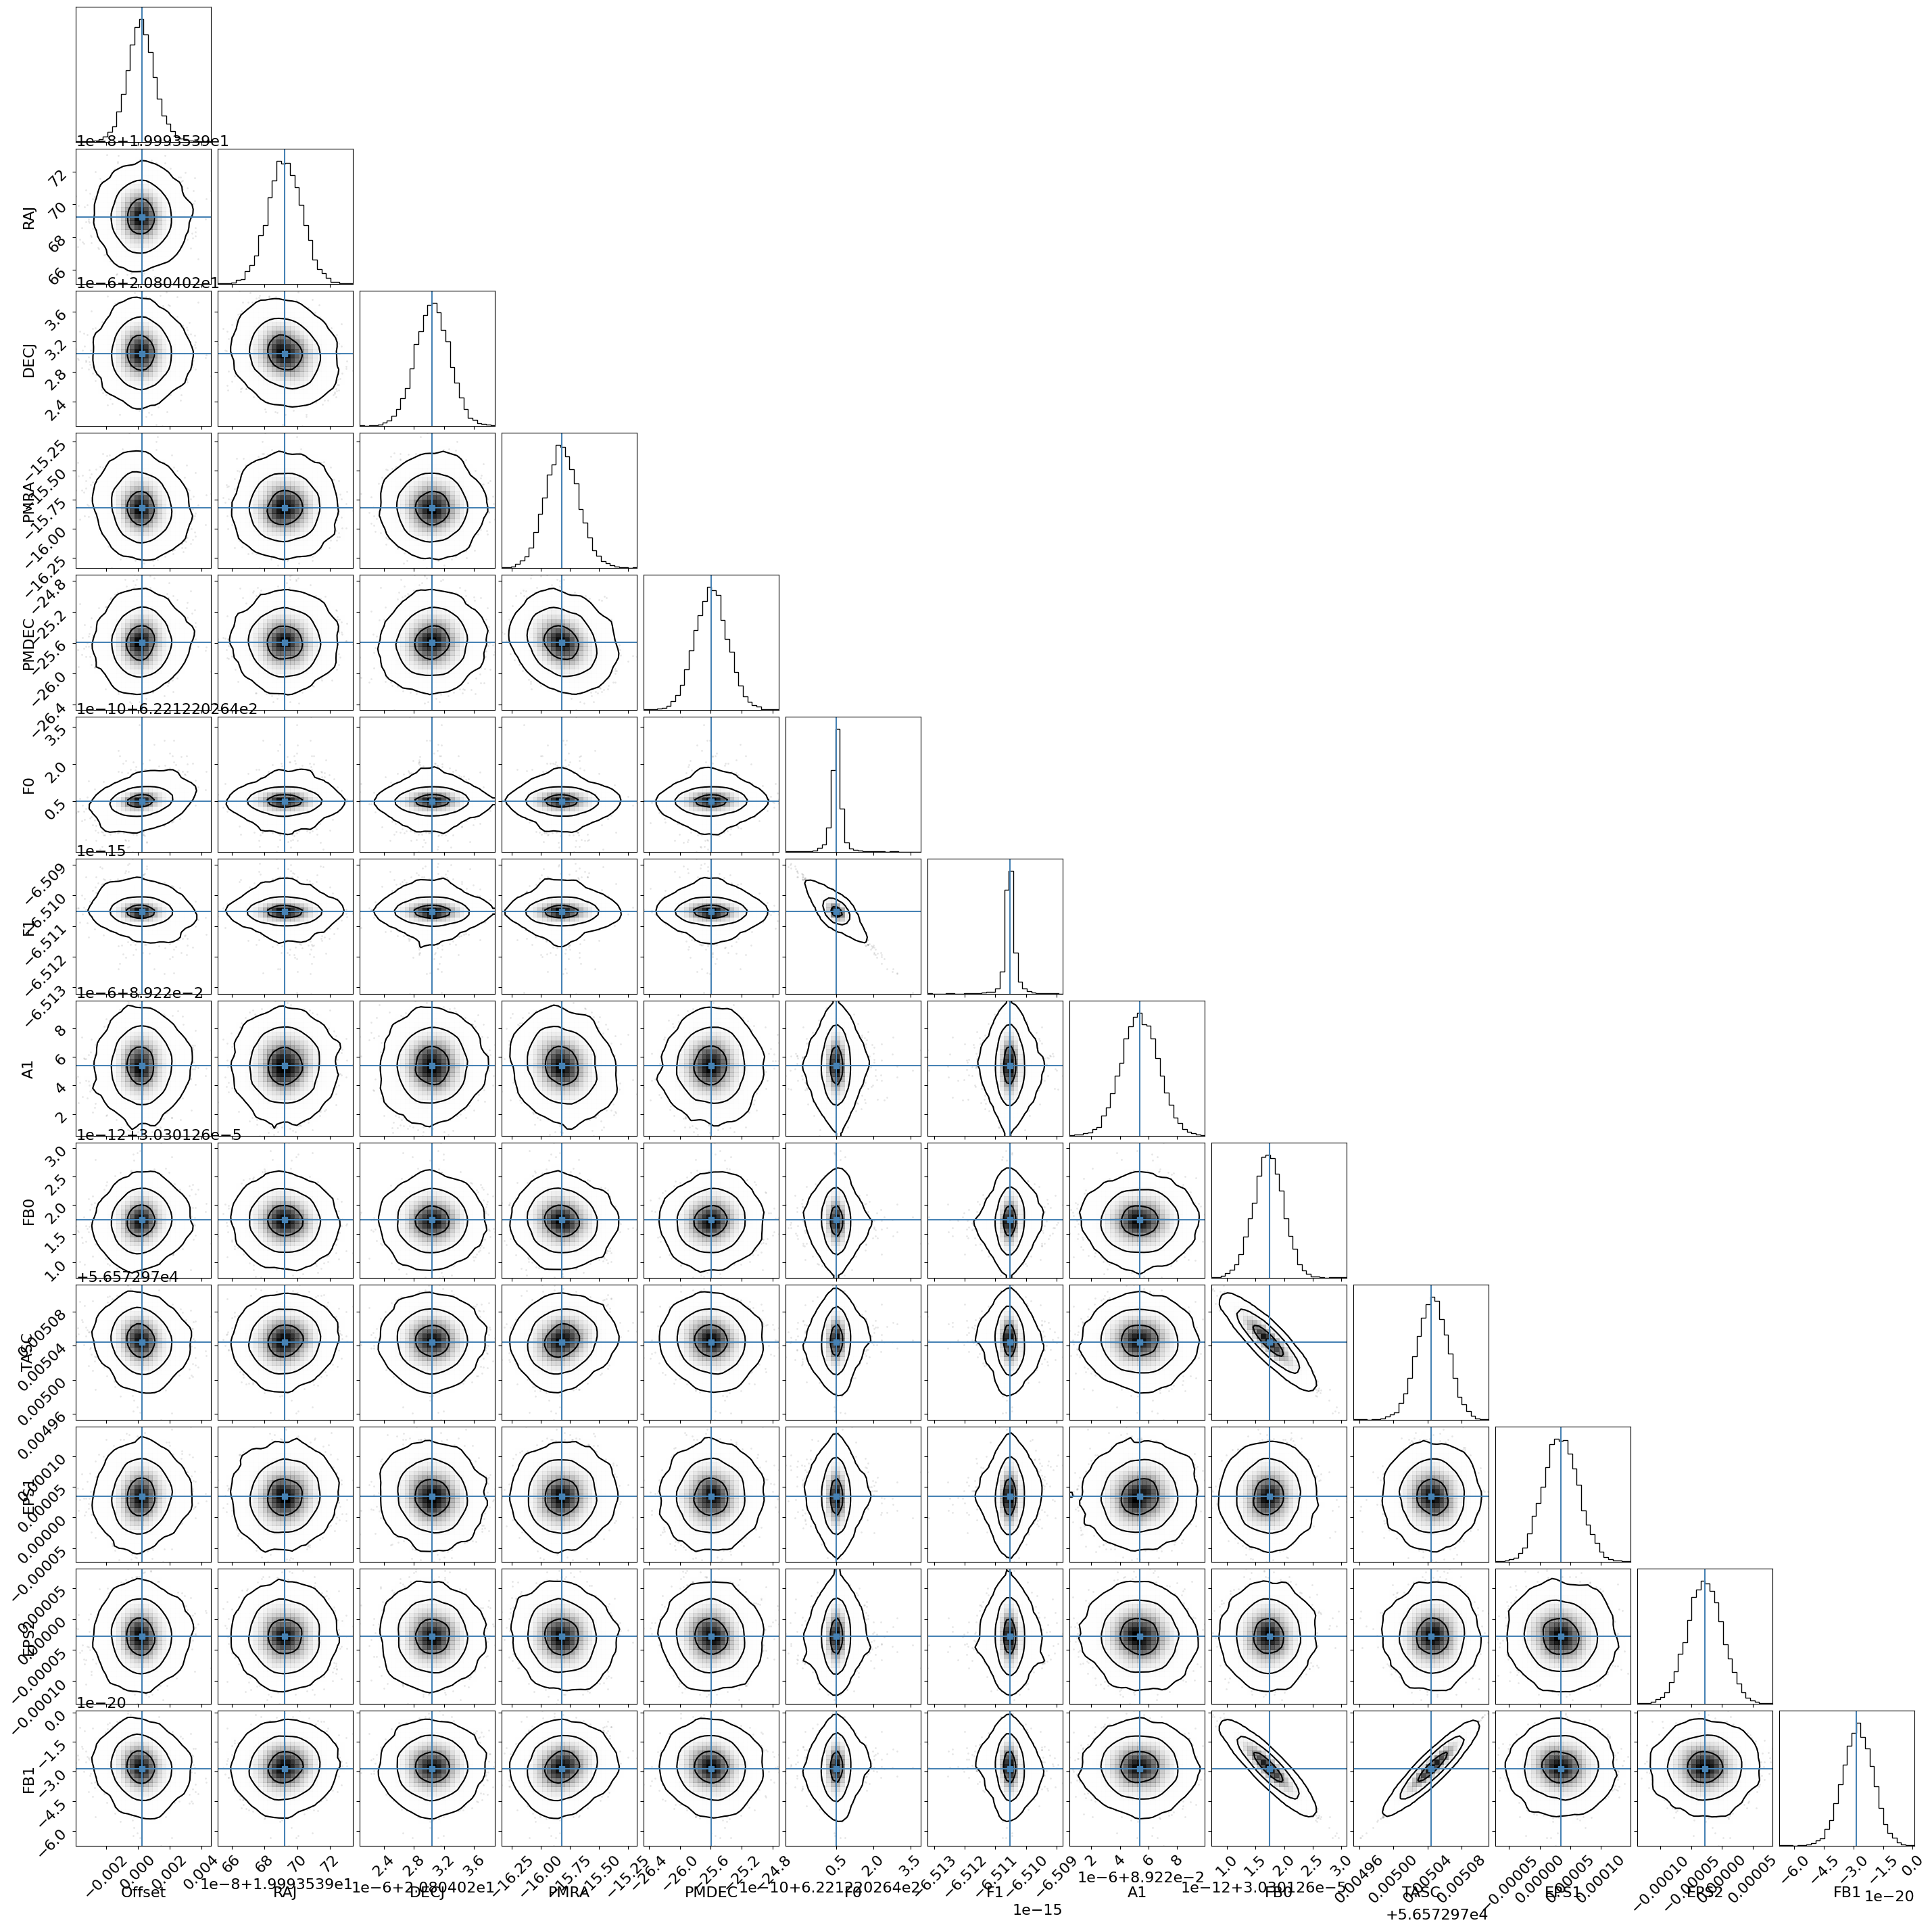

In [15]:
fig = res.timing_corner(nWX=psr.nWXfreqs)
plt.show()


### Compute an upper limit on the GWB amplitude

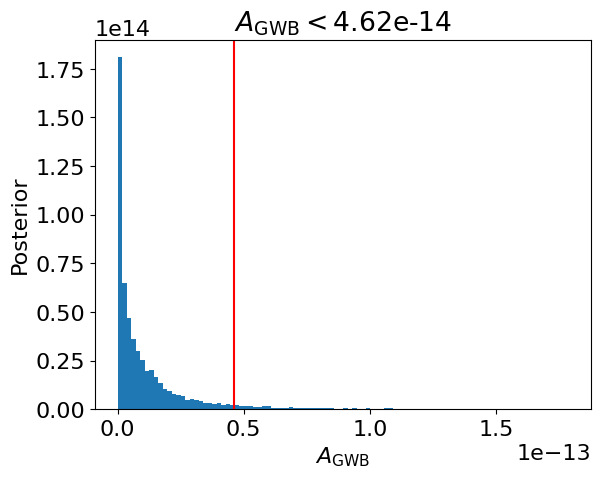

In [16]:
logAgwbs = res.hyp_chain[:,0]

Agwbs = 10 ** logAgwbs
plt.hist(Agwbs,100,density=True)
plt.xlabel('$A_{\\rm GWB}$')
plt.ylabel('Posterior')
A_95 = np.quantile(Agwbs, 0.95)
plt.axvline(A_95,color='red')
plt.title(f'$A_{{\\rm GWB}} < ${A_95:.3g}')
plt.show()


### Create Fig 4 from the paper

33.1385784280097 us2 yr
0.21186016631215301 s2 yr
999

/var/folders/mq/jmhb888d64b93t2b98ykmvsw0000gn/T/ipykernel_7254/340361177.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


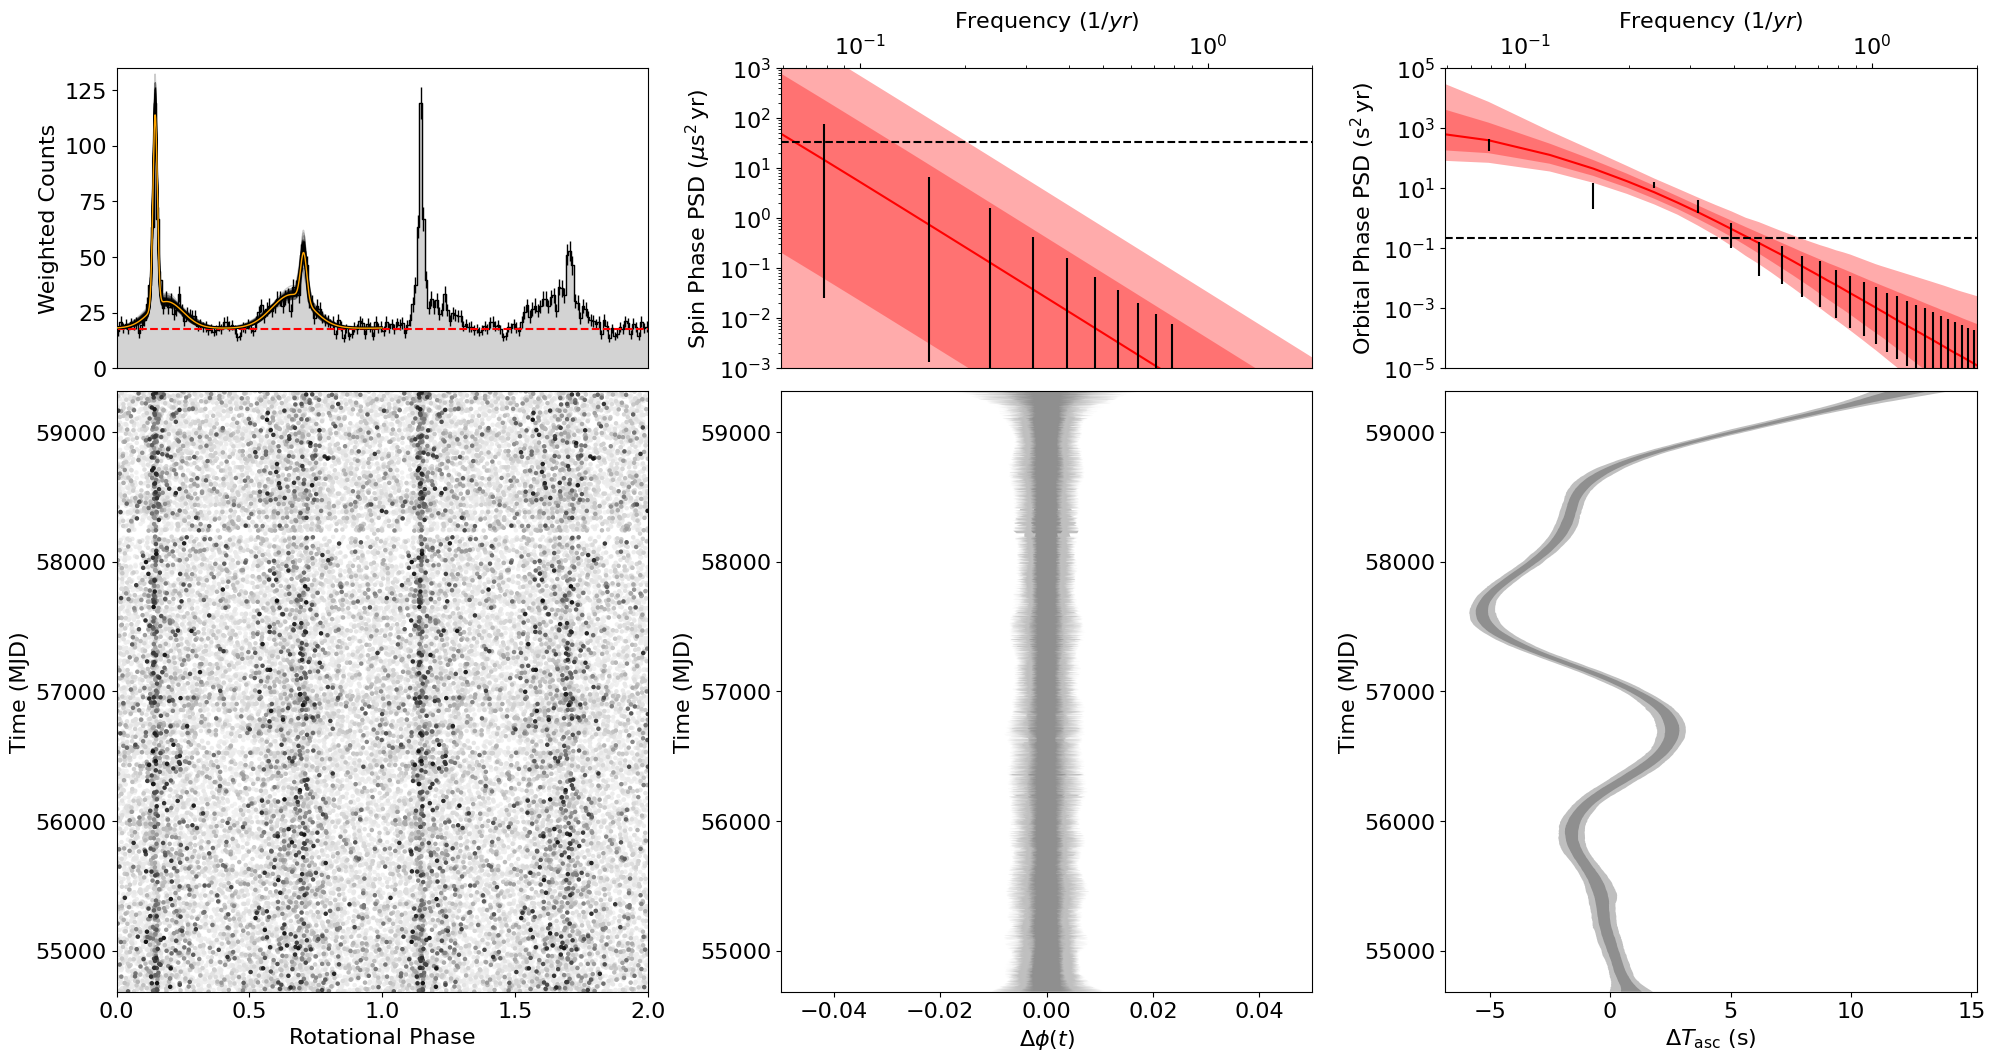

In [17]:
plt.rc('font',size=16)
ax = res.summary_plot(xbins=100, tn_yunits="us ** 2 * yr")
ax[0,1].set_ylim(bottom=1e-3, top=1e3)
ax[0,2].set_ylim(top=1e5,bottom=1e-5)
ax[0,2].set_xlim(left=0.75 / psr.Tobs * 365.25, right=2)
ax[0,1].set_xlim(left=0.75 / psr.Tobs * 365.25, right=2)
ax[1,1].set_xlim(-0.05,0.05)
ax[0,0].set_ylim(top=135)
ax[0,1].set_ylabel('Spin Phase PSD ($\\mu {\\rm s}^2\\, {\\rm yr}$)')
ax[0,2].set_ylabel('Orbital Phase PSD (${\\rm s}^2\\, {\\rm yr}$)')
plt.tight_layout()
plt.show()
